In [1]:
from MieSppForce import  green_func, frenel
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import quad
from MieSppForce.directivity import get_directivity

c_const = 299792458
eps0_const = 1/(4*np.pi*c_const**2)*1e7
mu0_const = 4*np.pi * 1e-7
eps_Au = frenel.get_interpolate('Au')
eps_Si = frenel.get_interpolate('Si')
wl = 800
z0 = np.linspace(0,160, 100, dtype=int)
k0 = lambda wl: 2*np.pi/wl
STOP=45

In [23]:
from MieSppForce import dipoles, force
from tqdm import tqdm


dxGExz = np.empty(len(z0), dtype=complex) #imag
dyGEyz = np.empty(len(z0), dtype=complex) #imag
dxGHxz = np.empty(len(z0), dtype=complex) #imag
dyGHyz = np.empty(len(z0), dtype=complex) #imag

dxrotGHyz = np.empty(len(z0), dtype=complex) #imag
dxrotGHzy = np.empty(len(z0), dtype=complex) #imag
dyrotGHxz = np.empty(len(z0), dtype=complex) #imag
dyrotGHzx = np.empty(len(z0), dtype=complex) #imag

P,M =  np.empty((len(z0),3), dtype=complex),np.empty((len(z0),3), dtype=complex)
R= 110
a_angle = 0
angle = 25*np.pi/180
phase = 0
F_x, F_y, F_z = np.empty((len(z0), 8)),np.empty((len(z0), 8)), np.empty((len(z0), 8))

for i in tqdm(range(len(z0))):
    point=[0,0,z0[i]]
    p,m = dipoles.calc_dipoles_v2(wl, eps_Au, point, R, eps_Si, angle, amplitude=1, phase=phase, a_angle=a_angle, stop=STOP)
    p,m = p[:,0],m[:,0]
    P[i,:],M[i,:]=p,m
    
    f =  force.F(wl, eps_Au, point, R, eps_Si, angle,amplitude=1,phase=phase,a_angle=a_angle, stop=STOP, full_output=True)
    F_x[i,:] = f[0]
    F_y[i,:] = f[1]
    F_z[i,:] = f[2]
    
    _, dyrotGH = green_func.dy_rot_green_E_H(wl, z0[i], eps_Au, STOP)
    _, dxrotGH = green_func.dx_rot_green_E_H(wl, z0[i], eps_Au, STOP)
    
    dxGE,dxGH = green_func.dx_green_E_H(wl, z0[i], eps_Au, STOP)
    dyGE,dyGH = green_func.dy_green_E_H(wl, z0[i], eps_Au, STOP)
    
    dxGExz[i] = dxGE[0,2]
    dxGHxz[i] = dxGH[0,2]
    dyGEyz[i] = dyGE[1,2]
    dyGHyz[i] = dyGH[1,2]

    dxrotGHyz[i], dxrotGHzy[i] = dxrotGH[1,2], dxrotGH[2,1]
    dyrotGHxz[i], dyrotGHzx[i] = dyrotGH[0,2], dyrotGH[2,0]


100%|██████████| 100/100 [00:00<00:00, 1041.69it/s]


In [24]:

f0 = force.F(wl, 1, [0,0,0], R, eps_Si, 0,amplitude=1,phase=0,a_angle=0, stop=STOP, full_output=False)[2]
f0 = np.abs(f0)


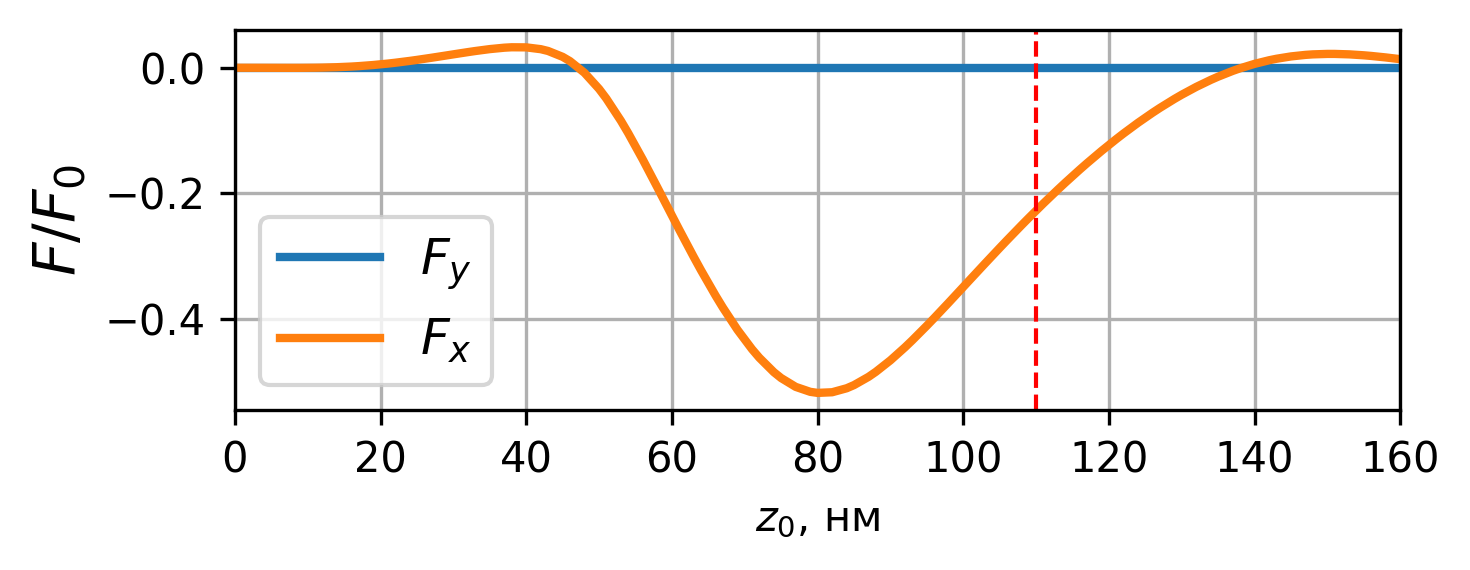

In [25]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2), sharex=True, dpi=300)


ax1.plot(z0, F_y[:,0]/f0, label='$F_y$', linewidth=2, color='#1f77b4')
ax1.plot(z0, (F_x[:,0]-F_x[:,1]-F_x[:,4])/f0, label='$F_x$', linewidth=2, color='#ff7f0e')

ax1.set_ylabel('$F/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(fontsize=12)
ax1.set_xlabel('$z_0$, нм')

plt.xlim(z0[0], z0[-1])

plt.axvline(R, color='red', linestyle='--', linewidth=1)

plt.tight_layout()
#plt.savefig(f'f_no_sc_from_z0_R_{R}_wl_{wl}.pdf', dpi=300)
plt.show()




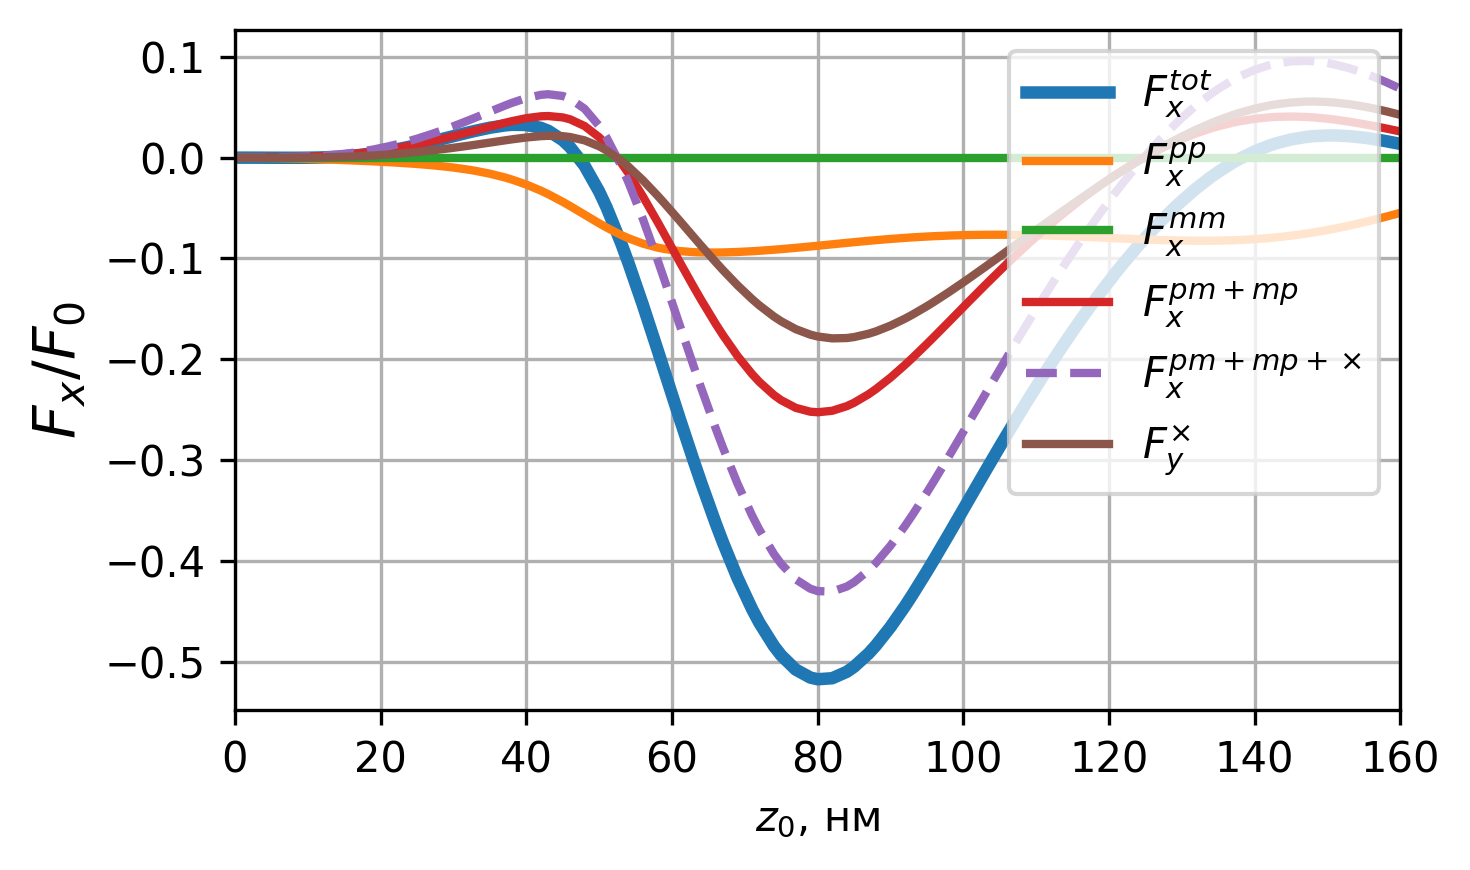

In [31]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 3), sharex=True, dpi=300)


ax1.plot(z0, (F_x[:,0]-F_x[:,1]-F_x[:,4])/f0, label='$F_x^{tot}$', linewidth=3)
ax1.plot(z0, F_x[:,2]/f0, label='$F_x^{pp}$', linewidth=2)
ax1.plot(z0, F_x[:,5]/f0, label='$F_x^{mm}$', linewidth=2)
ax1.plot(z0, (F_x[:,6]+F_x[:,3])/f0, label='$F_x^{pm+mp}$', linewidth=2)
ax1.plot(z0, (F_x[:,6]+F_x[:,3]+F_x[:,7])/f0, label='$F_x^{pm+mp+\\times}$', linewidth=2, ls='--')
ax1.plot(z0, F_x[:,7]/f0, label='$F_y^{\\times}$', linewidth=2)

ax1.set_ylabel('$F_x/F_0$', fontsize=14)
ax1.grid(True)
ax1.legend(loc='upper right')
ax1.set_xlabel('$z_0$, нм')

plt.xlim(z0[0], z0[-1])

plt.tight_layout()
#plt.savefig(f'f_no_sc_y_from_z0_R_{R}_wl_{wl}.pdf', dpi=300)
plt.show()




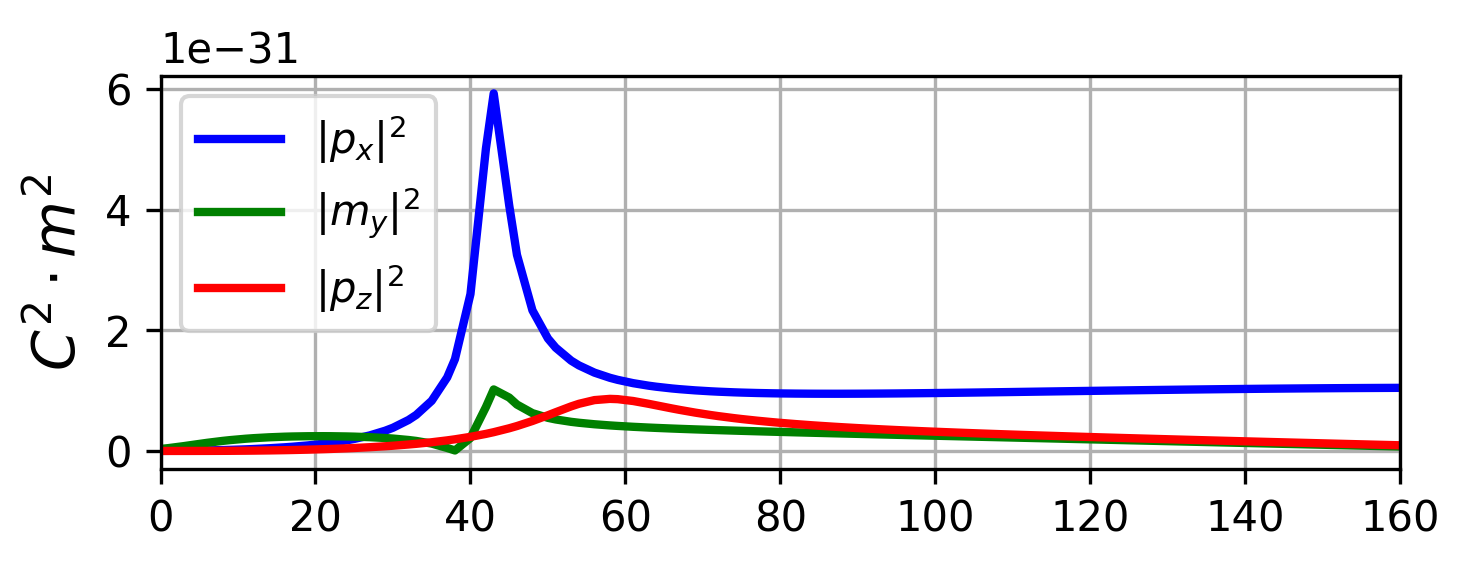

In [28]:
fig, ax1 = plt.subplots(1, 1, figsize=(5, 2), sharex=True, dpi=300)

ax1.plot(z0, np.abs(P[:,0]), label='|$p_x|^2$', color='blue', lw=2)
ax1.plot(z0, np.abs(M[:,1])/c_const, label='$|m_y|^2$', color='green', lw=2)  
#ax1.plot(z0, np.abs(P[:,1]), label='$|p_y|^2$', color='green', lw=2)   
ax1.plot(z0, np.abs(P[:,2]), label='$|p_z|^2$', color='red', lw=2)

# ax2.plot(z0, np.abs(M[:,0])/c_const, label='$|m_x|^2$', color='blue', lw=2)
# ax2.plot(z0, np.abs(M[:,1])/c_const, label='$|m_y|^2$', color='green', lw=2)   
# ax2.plot(z0, np.abs(M[:,2])/c_const, label='$|m_z|^2$', color='red', lw=2)


ax1.set_ylabel('$C^2 \\cdot m^2$', fontsize=14)
ax1.grid(True)
ax1.legend(loc='upper left')



# ax2.set_ylabel('$m, C^2 \\cdot m^2$', fontsize=14)
# ax2.grid(True)
# ax2.legend(loc='upper left')
# ax2.set_xlabel('$z_0$, нм')

plt.xlim(z0[0], z0[-1])

plt.tight_layout()
#plt.savefig(f'p_m_spp_from_z0_R_{R}_wl_{wl}.pdf', dpi=300)
plt.show()

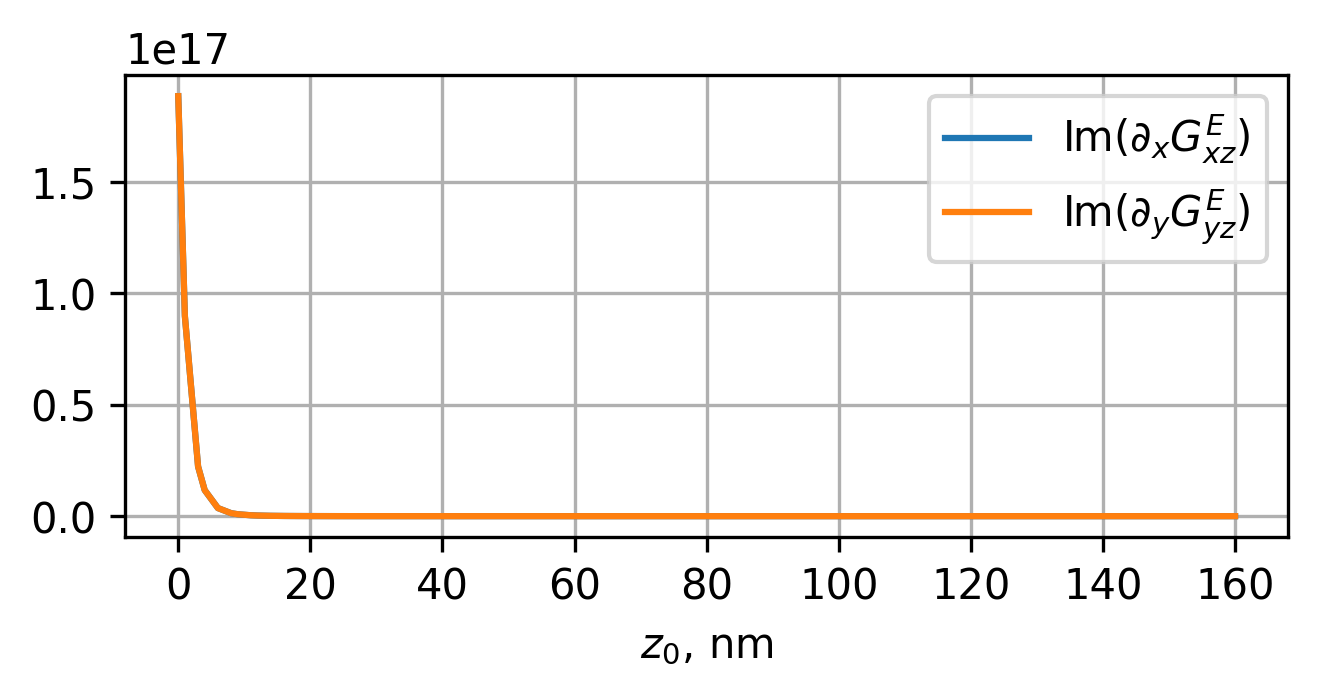

In [17]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(z0, dxGExz.imag, label='Im($\\partial_x G^E_{xz}$)')
plt.plot(z0, dyGEyz.imag, label='Im($\\partial_y G^E_{yz}$)')
plt.legend()
plt.grid()
plt.xlabel('$z_0$, nm')
plt.savefig('dxGE_dyGE_from_z0.png', dpi=300, bbox_inches='tight')

# plt.plot(z0, dyGEyz.imag)

# plt.plot(z0, dyGHyz.imag)

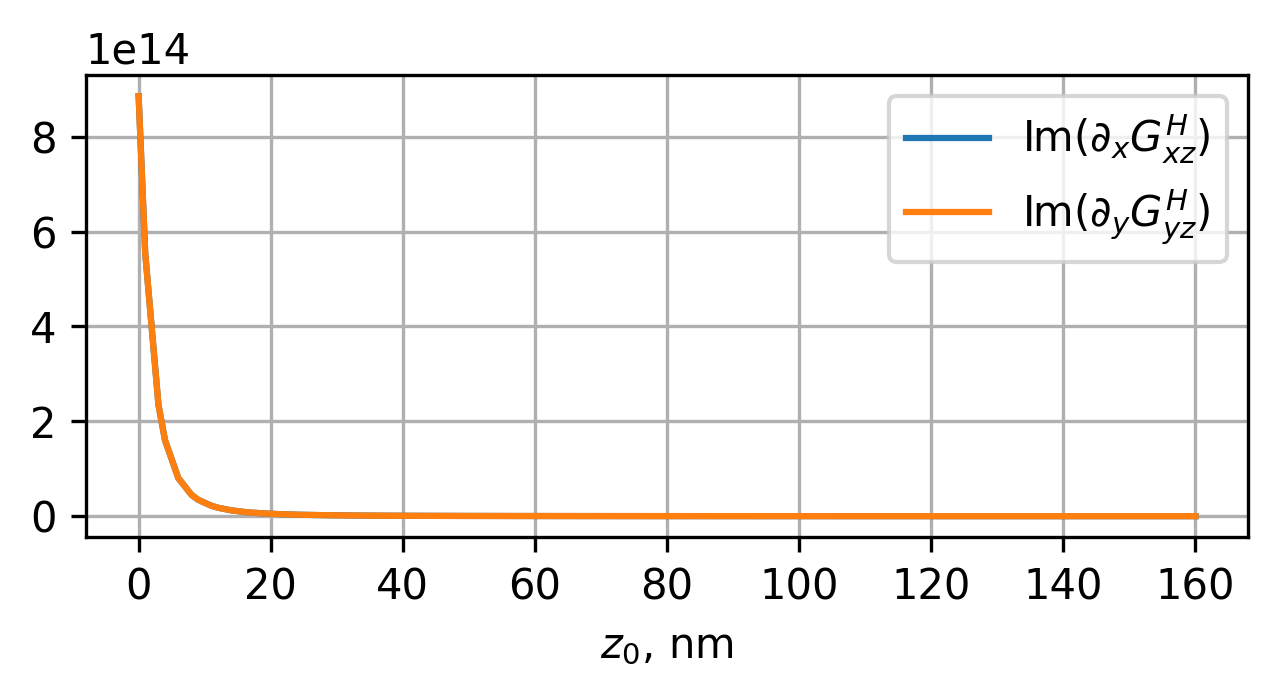

In [6]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(z0, dxGHxz.imag, label='Im($\\partial_x G^H_{xz}$)')
plt.plot(z0, dyGHyz.imag, label='Im($\\partial_y G^H_{yz}$)')
plt.legend()
plt.grid()
plt.xlabel('$z_0$, nm')
plt.savefig('dxGH_dyGH_from_z0.png', dpi=300, bbox_inches='tight')

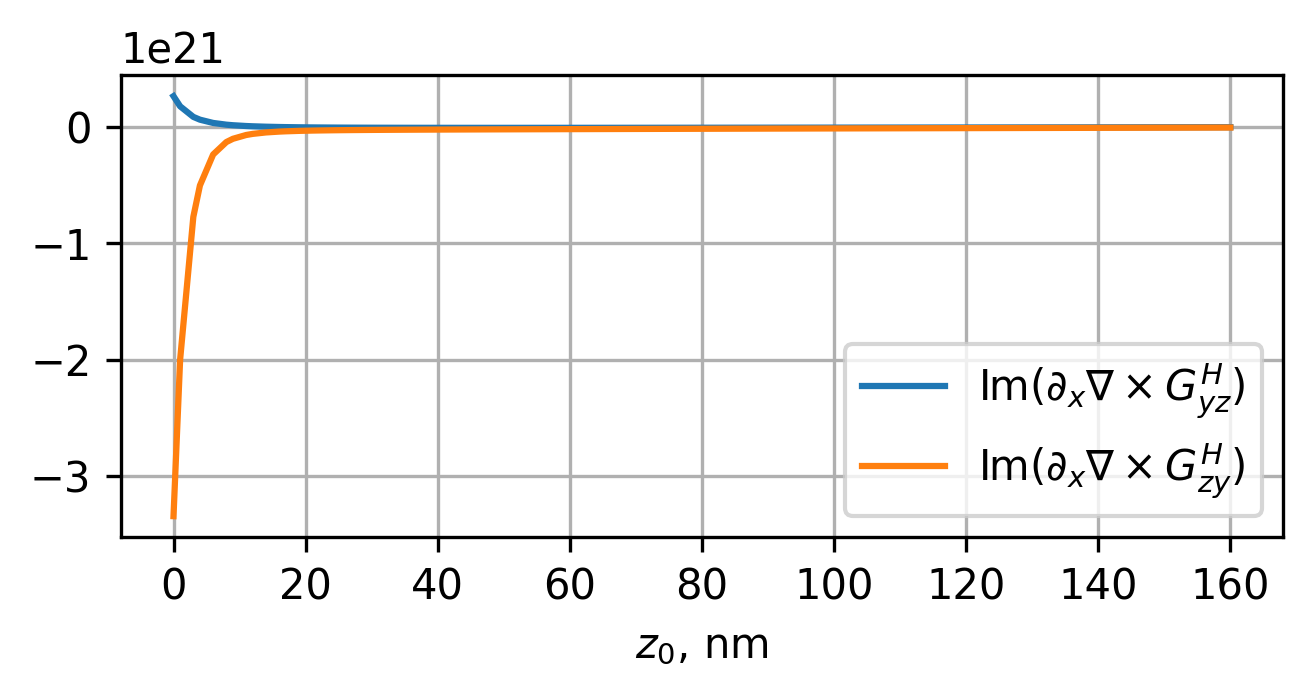

In [7]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(z0, dxrotGHyz.imag, label='Im($\\partial_x \\nabla \\times G^H_{yz}$)')
plt.plot(z0, dxrotGHzy.imag, label='Im($\\partial_x \\nabla \\times G^H_{zy}$)')
plt.legend()
plt.grid()
plt.xlabel('$z_0$, nm')
plt.savefig('dx_dy_rotGH_from_z0.png', dpi=300, bbox_inches='tight')

Text(0.5, 0, '$z_0$')

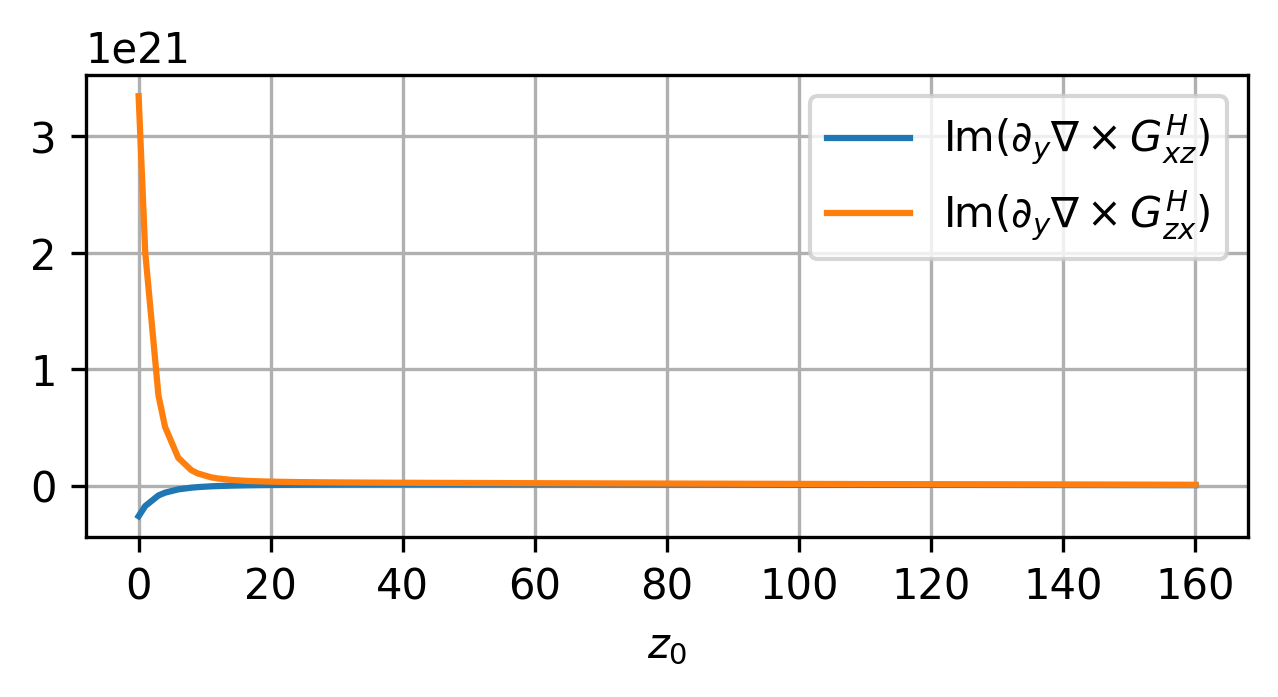

In [8]:
plt.figure(figsize=(5, 2), dpi=300)
plt.plot(z0, dyrotGHxz.imag, label='Im($\\partial_y \\nabla \\times G^H_{xz}$)')
plt.plot(z0, dyrotGHzx.imag, label='Im($\\partial_y \\nabla \\times G^H_{zx}$)')
plt.legend()
plt.grid()
plt.xlabel('$z_0$')